In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
from matplotlib.ticker import FuncFormatter
% matplotlib inline

In [2]:
nStartMasternodePayments = 1524146400; #19 Apr 2018 22:00:00 GMT
block2001Time = 1527483752 # 28th May 2018 13:02:32
block1Time = 1527248670  # 25th May 2018 19:44:30
averageBlockTime = 126 # 平均区块时间2分零6秒

In [3]:
"""
给定区块高度获得区块奖励(float)
"""
def GetBlockValue(nHeight:int):
    nSubsidy = 0
    LAST_POW_BLOCK = 23600
    COIN = 1    
    
    if (nHeight == 0):
        nSubsidy = 7000000 * COIN;
    elif (nHeight < 2000 and nHeight > 0):
        nSubsidy = 1 * COIN;
    elif (nHeight < LAST_POW_BLOCK and nHeight >= 2000):
        nSubsidy = 100 * COIN;
    elif (nHeight < 300000 and nHeight >= LAST_POW_BLOCK) :
        nSubsidy = 100 * COIN;
    elif (nHeight < 1000000 and nHeight >= 300000):
        nSubsidy = 50 * COIN;
    elif (nHeight < 2000000 and nHeight >= 1000000):
        nSubsidy = 25 * COIN;
    elif (nHeight < 3000000 and nHeight >= 2000000): 
        nSubsidy = 12.5 * COIN;
    else:
        nSubsidy = 6.25 * COIN;
               
    # Super block
    nTail = nHeight - int(nHeight / 21600) * 21600;
    if (nHeight > LAST_POW_BLOCK and nTail >= 0 and nTail < 15):
        nSubsidy = 1000 * COIN;

    return nSubsidy;

"""
输入两个区块高度（或时间），返回膨胀率(float)
"""
def InflationRate(arg1,arg2):        
    if type(arg1)==str:
        ts1 = np.datetime64(arg1 , 's').astype('int64')
        block1 = math.floor((ts1 - block1Time)/averageBlockTime)
    else:
        block1 = arg1
        
    if type(arg2)==str:
        ts2 = np.datetime64(arg2 , 's').astype('int64')
        block2 = math.floor((ts2 - block1Time)/averageBlockTime)
    else:
        block2 = arg2     
        
    if block1>=block2:
        block1,block2 = block2,block1
        
    block1List = np.arange(block1)
    block2List = np.arange(block2)
    GetBlockValueFunc = np.vectorize(GetBlockValue)
    
    block1Last = np.cumsum(GetBlockValueFunc(block1List))[-1]
    block2Last = np.cumsum(GetBlockValueFunc(block2List))[-1]
    
    return block2Last/block1Last


"""
给定区块高度（或时间），获得流通数量(float)
"""
def GetCirculatingSupply(arg):
    if type(arg)==int or type(arg)==float:
        nHeight = arg
    elif type(arg) == str or type(arg)==np.datetime64:
        ts = np.datetime64(arg , 's').astype('int64')
        nHeight = math.floor((ts - block1Time)/averageBlockTime)
        
    blockIndexes = np.arange(nHeight)
    GetBlockValueFunc = np.vectorize(GetBlockValue)
    cumsum = np.cumsum(GetBlockValueFunc(blockIndexes))
    return cumsum[-1]


"""
给定区块高度(或时间)，获得真实年化ROI
"""
def GetRealROIAnnual(arg):
    if type(arg)==int:
        nHeight = arg
    else:
        ts = np.datetime64(arg , 's').astype('int64')
        nHeight = math.floor((ts - block1Time)/averageBlockTime)
    AnnualBlockCount = 365*24*60*60/averageBlockTime
    return GetCirculatingSupply(nHeight+AnnualBlockCount)/GetCirculatingSupply(nHeight)

"""
给定区块高度，返回时间
"""
def GetTimeFromHeight(height):
    ts = height*averageBlockTime+block1Time
    return np.datetime64(ts , 's')

In [4]:
# 第一次减半 300000 到50
print(GetTimeFromHeight(300000))
# 第二次减半 1000000 到25
print(GetTimeFromHeight(1000000))
# 第三次减半 2000000 到12.5
print(GetTimeFromHeight(2000000))
# 第四次减半 3000000 到6.25
print(GetTimeFromHeight(3000000))

2019-08-05T23:44:30
2022-05-22T19:44:30
2026-05-20T03:44:30
2030-05-17T11:44:30


In [5]:
t = np.arange('2018-05-26', '2022-05-26',np.timedelta64(4,'W'), dtype='datetime64')

GetRealROIAnnualFun = np.vectorize(GetRealROIAnnual)

RealROIX = GetRealROIAnnualFun(t)

print(RealROIX) 

[4.57128623 3.87508312 3.35933337 2.96499361 2.63780952 2.38741019
 2.18883011 2.02869577 1.89635743 1.78515585 1.69127492 1.60947089
 1.53821193 1.4755825  1.42010454 1.37022125 1.33919946 1.33057788
 1.32238372 1.3150512  1.30760819 1.30050874 1.2937296  1.28724957
 1.28073358 1.27480197 1.26911584 1.26366025 1.25878729 1.25374407
 1.24889365 1.24422518 1.23972863 1.23513022 1.23095487 1.22692522
 1.22303377 1.21957428 1.21593287 1.21241026 1.20133084 1.19037284
 1.17952222 1.16923382 1.15925579 1.14957429 1.14042051 1.13128829
 1.12241593 1.1137925  1.10540766 1.09704682 1.08911316]


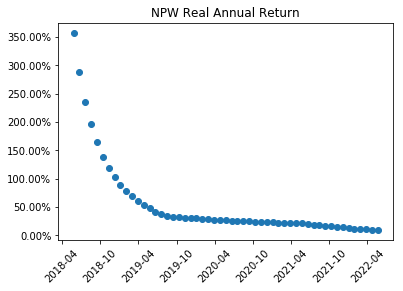

In [6]:
f, ax = plt.subplots()
ax.set_title('NPW Real Annual Return')
ax.plot_date(t, RealROIX-1) 
plt.xticks(rotation=45)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

In [7]:
tempPrice = 400000000/GetCirculatingSupply('2019-08-05')
tempChildren = InflationRate('2018-09-18','2019-08-05')
fairValue = tempPrice * tempChildren
print(f'''19年8月会第一次减半，届时年通胀维持在35%以下。
如果达到了 PIVX 目前的￥4亿市值，币价会是{tempPrice:.2f}元。
你目前 0.000006BTC，也就是￥2.5卖掉的1NPW，在那时会变成{tempChildren:.2f}个
换句话说，现在的1NPW，到时候会价值￥{fairValue:.2f}''')

19年8月会第一次减半，届时年通胀维持在35%以下。
如果达到了 PIVX 目前的￥4亿市值，币价会是10.84元。
你目前 0.000006BTC，也就是￥2.5卖掉的1NPW，在那时会变成2.50个
换句话说，现在的1NPW，到时候会价值￥27.12


In [8]:
tempPrice = 8000000000/GetCirculatingSupply('2022-05-22')
tempChildren = InflationRate('2018-09-18','2022-05-22')
fairValue = tempPrice * tempChildren
print(f'''22年5月会第二次减半，届时年通胀维持在10%以下。
如果达到了 DASH 目前的￥80亿市值，币价会是{tempPrice:.2f}元。
你目前 0.00006BTC，也就是￥2.5卖掉的1NPW，在那时会变成{tempChildren:.2f}个
换句话说，现在的1NPW，到时候会价值￥{fairValue:.2f}''')

22年5月会第二次减半，届时年通胀维持在10%以下。
如果达到了 DASH 目前的￥80亿市值，币价会是110.49元。
你目前 0.00006BTC，也就是￥2.5卖掉的1NPW，在那时会变成4.91个
换句话说，现在的1NPW，到时候会价值￥542.38
